
# PART I: Running a SpeechBrain ASR Recipe

### Setting up the codebase.

In [1]:
%%capture

# Clone SpeechBrain repository
!git clone https://github.com/Darshan7575/speechbrain.git
%cd /content/speechbrain/

# Install required dependencies
!pip install -r requirements.txt

# Install SpeechBrain in editable mode
!pip install -e .

In [2]:
# Required imports
import os
import json
import shutil
import logging
import sys
import torch
from pathlib import Path
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from speechbrain.utils.data_utils import get_all_files, download_file
from speechbrain.dataio.dataio import read_audio
from speechbrain.utils.distributed import run_on_main, if_main_process

# Required variables and loggers
logger = logging.getLogger(__name__)
logger = logging.getLogger(__name__)
MINILIBRI_TRAIN_URL = "http://www.openslr.org/resources/31/train-clean-5.tar.gz"
MINILIBRI_VALID_URL = "http://www.openslr.org/resources/31/dev-clean-2.tar.gz"
MINILIBRI_TEST_URL = "https://www.openslr.org/resources/12/test-clean.tar.gz"
SAMPLERATE = 16000

device="cuda"
run_opts = {'device':device}

### Tokenizer Training
In this section, we will train a BPE tokenizer with **150 tokens** using `Sentencepiece`.



In [3]:
# ############################################################################
# Dataset creation helper functions
# ############################################################################

def prepare_mini_librispeech(
    data_folder, save_json_train, save_json_valid, save_json_test
):
    """
    Prepares the json files for the Mini Librispeech dataset.
    Downloads the dataset if its not found in the `data_folder`.
    """

    # Check if this phase is already done (if so, skip it)
    if skip(save_json_train, save_json_valid, save_json_test):
        logger.info("Preparation completed in previous run, skipping.")
        return

    # If the dataset doesn't exist yet, download it
    train_folder = os.path.join(data_folder, "LibriSpeech", "train-clean-5")
    valid_folder = os.path.join(data_folder, "LibriSpeech", "dev-clean-2")
    test_folder = os.path.join(data_folder, "LibriSpeech", "test-clean")
    if not check_folders(train_folder, valid_folder, test_folder):
        download_mini_librispeech(data_folder)

    # List files and create manifest from list
    logger.info(
        f"Creating {save_json_train}, {save_json_valid}, and {save_json_test}"
    )
    extension = [".flac"]

    # List of flac audio files
    wav_list_train = get_all_files(train_folder, match_and=extension)
    wav_list_valid = get_all_files(valid_folder, match_and=extension)
    wav_list_test = get_all_files(test_folder, match_and=extension)

    # List of transcription file
    extension = [".trans.txt"]
    trans_list = get_all_files(data_folder, match_and=extension)
    trans_dict = get_transcription(trans_list)

    # Create the json files
    create_json(wav_list_train, trans_dict, save_json_train)
    create_json(wav_list_valid, trans_dict, save_json_valid)
    create_json(wav_list_test, trans_dict, save_json_test)


def get_transcription(trans_list):
    """
    Returns a dictionary with the transcription of each sentence in the dataset.
    """
    # Processing all the transcription files in the list
    trans_dict = {}
    for trans_file in trans_list:
        # Reading the text file
        with open(trans_file) as f:
            for line in f:
                uttid = line.split(" ")[0]
                text = line.rstrip().split(" ")[1:]
                text = " ".join(text)
                trans_dict[uttid] = text

    logger.info("Transcription files read!")
    return trans_dict


def create_json(wav_list, trans_dict, json_file):
    """
    Creates the json file given a list of wav files and their transcriptions.
    """
    # Processing all the wav files in the list
    json_dict = {}
    for wav_file in wav_list:

        # Reading the signal (to retrieve duration in seconds)
        signal = read_audio(wav_file)
        duration = signal.shape[0] / SAMPLERATE

        # Manipulate path to get relative path and uttid
        path_parts = wav_file.split(os.path.sep)
        uttid, _ = os.path.splitext(path_parts[-1])
        relative_path = os.path.join("{data_root}", *path_parts[-5:])

        # Create entry for this utterance
        json_dict[uttid] = {
            "wav": relative_path,
            "length": duration,
            "words": trans_dict[uttid],
        }

    # Writing the dictionary to the json file
    with open(json_file, mode="w") as json_f:
        json.dump(json_dict, json_f, indent=2)

    logger.info(f"{json_file} successfully created!")


def skip(*filenames):
    """
    Detects if the data preparation has been already done.
    If the preparation has been done, we can skip it.
    """
    for filename in filenames:
        if not os.path.isfile(filename):
            return False
    return True


def check_folders(*folders):
    """Returns False if any passed folder does not exist."""
    for folder in folders:
        if not os.path.exists(folder):
            return False
    return True


def download_mini_librispeech(destination):
    """Download dataset and unpack it.
    """
    train_archive = os.path.join(destination, "train-clean-5.tar.gz")
    valid_archive = os.path.join(destination, "dev-clean-2.tar.gz")
    test_archive = os.path.join(destination, "test-clean.tar.gz")
    download_file(MINILIBRI_TRAIN_URL, train_archive)
    download_file(MINILIBRI_VALID_URL, valid_archive)
    download_file(MINILIBRI_TEST_URL, test_archive)
    shutil.unpack_archive(train_archive, destination)
    shutil.unpack_archive(valid_archive, destination)
    shutil.unpack_archive(test_archive, destination)

In [4]:
tokenizer_hyperparams = """
# ############################################################################
# Tokenizer: subword BPE with unigram 150
# ############################################################################

output_folder: !ref results/tokenizer/

# Data files
data_folder: data
train_annotation: !ref <data_folder>/train.json
valid_annotation: !ref <data_folder>/valid.json
test_annotation: !ref <data_folder>/test.json

# Tokenizer training parameters
token_type: unigram  # ["unigram", "bpe", "char"]
token_output: 150  # index(blank/eos/bos/unk) = 0
character_coverage: 1.0
json_read: words

tokenizer: !name:speechbrain.tokenizers.SentencePiece.SentencePiece
   model_dir: !ref <output_folder>
   vocab_size: !ref <token_output>
   annotation_train: !ref <train_annotation>
   annotation_read: !ref <json_read>
   annotation_format: json
   model_type: !ref <token_type> # ["unigram", "bpe", "char"]
   character_coverage: !ref <character_coverage>
   annotation_list_to_check: [!ref <train_annotation>, !ref <valid_annotation>]

"""

In [5]:
# load required params from the hyperpyyaml file
hparams = load_hyperpyyaml(tokenizer_hyperparams)

# 1. Dataset creation

## Create experiment directory
sb.create_experiment_directory(
    experiment_directory=hparams["output_folder"],
    overrides=None,
)

## Create dataset
run_on_main(
    prepare_mini_librispeech,
    kwargs={
        "data_folder": hparams["data_folder"],
        "save_json_train": hparams["train_annotation"],
        "save_json_valid": hparams["valid_annotation"],
        "save_json_test": hparams["test_annotation"],
    },
)

# 2. Tokenizer training
hparams["tokenizer"]()

# 3. Saving tokenizer in .ckpt extension
output_path = hparams["output_folder"]
token_output = hparams["token_output"]
token_type = hparams["token_type"]
bpe_model = f"{output_path}/{token_output}_{token_type}.model"
tokenizer_ckpt = f"{output_path}/tokenizer.ckpt"
shutil.copyfile(bpe_model, tokenizer_ckpt)

speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/tokenizer/


train-clean-5.tar.gz: 333MB [00:19, 17.1MB/s]                           


dev-clean-2.tar.gz: 126MB [00:08, 14.6MB/s]                           


test-clean.tar.gz: 347MB [00:23, 14.7MB/s]                           


__main__ - Creating data/train.json, data/valid.json, and data/test.json
__main__ - Transcription files read!
__main__ - data/train.json successfully created!
__main__ - data/valid.json successfully created!
__main__ - data/test.json successfully created!
speechbrain.tokenizers.SentencePiece - Train tokenizer with type:unigram
speechbrain.tokenizers.SentencePiece - Extract words sequences from:data/train.json
speechbrain.tokenizers.SentencePiece - Text file created at: results/tokenizer/train.txt
speechbrain.tokenizers.SentencePiece - ==== Loading Tokenizer ===
speechbrain.tokenizers.SentencePiece - Tokenizer path: results/tokenizer/150_unigram.model
speechbrain.tokenizers.SentencePiece - Tokenizer vocab_size: 150
speechbrain.tokenizers.SentencePiece - Tokenizer type: unigram
speechbrain.tokenizers.SentencePiece - ==== Accuracy checking for recovering text from tokenizer ===
speechbrain.tokenizers.SentencePiece - recover words from: data/train.json
speechbrain.tokenizers.SentencePiece 

'results/tokenizer//tokenizer.ckpt'

### Model Training
In this section, we will train a **6 layer Conformer** encoder only architecture with the `CTC objective`.

In [6]:
global_hyperparams = """
# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 2024
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Data files
data_folder: data
train_annotation: !ref ./data/train.json
valid_annotation: !ref ./data/valid.json
test_annotation: !ref ./data/test.json

# Language model (LM) pretraining
pretrained_lm_tokenizer_path: ./results/tokenizer

# Training parameters
number_of_epochs: 30
batch_size: 8
lr_adam: 0.001
max_grad_norm: 5.0
ckpt_interval_minutes: 15 # save checkpoint every N min
loss_reduction: 'batchmean'

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>

valid_dataloader_opts:
    batch_size: !ref <batch_size>

test_dataloader_opts:
    batch_size: !ref <batch_size>

# Feature parameters
sample_rate: 16000
n_fft: 400
n_mels: 80

####################### Model parameters ###########################
# Transformer
d_model: 128
nhead: 4
num_encoder_layers: 6
d_ffn: 512
transformer_dropout: 0.1
activation: !name:torch.nn.GELU
output_neurons: 150
label_smoothing: 0.0
attention_type: RelPosMHAXL

# Outputs
blank_index: 0
pad_index: 0
bos_index: 1
eos_index: 2

# Decoding parameters
min_decode_ratio: 0.0
max_decode_ratio: 1.0
test_beam_size: 1
ctc_weight_decode: 1.0

############################## models ################################

compute_features: !new:speechbrain.lobes.features.Fbank
    sample_rate: !ref <sample_rate>
    n_fft: !ref <n_fft>
    n_mels: !ref <n_mels>

CNN: !new:speechbrain.lobes.models.convolution.ConvolutionFrontEnd
    input_shape: (8, 10, 80)
    num_blocks: 2
    num_layers_per_block: 1
    out_channels: (64, 32)
    kernel_sizes: (3, 3)
    strides: (2, 2)
    residuals: (False, False)

# standard parameters for the BASE model
Transformer: !new:speechbrain.lobes.models.transformer.TransformerASR.TransformerASR
    input_size: 640
    tgt_vocab: !ref <output_neurons>
    d_model: !ref <d_model>
    nhead: !ref <nhead>
    num_encoder_layers: !ref <num_encoder_layers>
    num_decoder_layers: 0
    d_ffn: !ref <d_ffn>
    dropout: !ref <transformer_dropout>
    activation: !ref <activation>
    encoder_module: conformer
    attention_type: !ref <attention_type>
    normalize_before: True

tokenizer: !new:sentencepiece.SentencePieceProcessor

ctc_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <d_model>
    n_neurons: !ref <output_neurons>

normalize: !new:speechbrain.processing.features.InputNormalization
    norm_type: global
    update_until_epoch: 4

modules:
    CNN: !ref <CNN>
    Transformer: !ref <Transformer>
    ctc_lin: !ref <ctc_lin>
    normalize: !ref <normalize>

model: !new:torch.nn.ModuleList
    - [!ref <CNN>, !ref <Transformer>, !ref <ctc_lin>]

# define two optimizers here for two-stage training
Adam: !name:torch.optim.Adam
    lr: !ref <lr_adam>
    betas: (0.9, 0.98)
    eps: 0.000000001

log_softmax: !new:torch.nn.LogSoftmax
    dim: -1

ctc_cost: !name:speechbrain.nnet.losses.ctc_loss
    blank_index: !ref <blank_index>
    reduction: !ref <loss_reduction>

noam_annealing: !new:speechbrain.nnet.schedulers.NoamScheduler
    lr_initial: !ref <lr_adam>
    n_warmup_steps: 1500

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

error_rate_computer: !name:speechbrain.utils.metric_stats.ErrorRateStats

cer_computer: !name:speechbrain.utils.metric_stats.ErrorRateStats
   split_tokens: True

# The pretrainer allows a mapping between pretrained files and instances that
# are declared in the yaml. E.g here, we will download the file tokenizer.ckpt
# and it will be loaded into "tokenizer" which is pointing to the <pretrained_lm_tokenizer_path> defined
# before.
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    loadables:
        tokenizer: !ref <tokenizer>
    paths:
        tokenizer: !ref <pretrained_lm_tokenizer_path>/tokenizer.ckpt
"""

In [7]:
def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.
    """
    # Define audio pipeline. In this case, we simply read the path contained
    # in the variable wav with the audio reader.
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        """Load the audio signal. This is done on the CPU in the `collate_fn`."""
        sig = sb.dataio.dataio.read_audio(wav)
        return sig

    tokenizer = hparams["tokenizer"]
    # Define text processing pipeline. We start from the raw text and then
    # encode it using the tokenizer. The tokens with BOS are used for feeding
    # decoder during training, the tokens with EOS for computing the cost function.
    # The tokens without BOS or EOS is for computing CTC loss.
    @sb.utils.data_pipeline.takes("words")
    @sb.utils.data_pipeline.provides(
        "wrd", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
    )
    def text_pipeline(wrd):
        """Processes the transcriptions to generate proper labels"""
        yield wrd
        tokens_list = tokenizer.encode_as_ids(wrd)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens

    # Define datasets from json data manifest file
    # Define datasets sorted by ascending lengths for efficiency
    datasets = {}
    data_folder = hparams["data_folder"]
    for dataset in ["train", "valid", "test"]:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=hparams[f"{dataset}_annotation"],
            replacements={"data_root": data_folder},
            dynamic_items=[audio_pipeline, text_pipeline],
            output_keys=[
                "id",
                "sig",
                "wrd",
                "tokens_bos",
                "tokens_eos",
                "tokens",
            ],
        )
        hparams[f"{dataset}_dataloader_opts"]["shuffle"] = False

    datasets["train"] = datasets["train"].filtered_sorted(sort_key="length")
    hparams["train_dataloader_opts"]["shuffle"] = False

    return (
        datasets["train"],
        datasets["valid"],
        datasets["test"],
        tokenizer
    )

In [8]:
# Define training procedure
class BaseASR(sb.Brain):
    def __init__(
        self,
        modules=None,
        opt_class=None,
        hparams=None,
        run_opts=None,
        checkpointer=None,
        profiler=None,
        tokenizer=None,
    ):
        super(BaseASR, self).__init__(
            modules=modules,
            opt_class=opt_class,
            hparams=hparams,
            run_opts=run_opts,
            checkpointer=checkpointer,
            profiler=profiler
        )
        self.tokenizer = tokenizer

    def compute_forward(self, batch, stage):
        """Performs a forward pass through the encoder"""
        batch = batch.to(self.device)
        wavs, wav_lens = batch.sig
        tokens_bos, _ = batch.tokens_bos

        # compute features
        feats = self.hparams.compute_features(wavs) #### FILL THIS WITH YOUR CODE FROM PART I ####
        current_epoch = self.hparams.epoch_counter.current
        feats = self.modules.normalize(feats, wav_lens, epoch=current_epoch)

        # forward modules
        src = self.modules.CNN(feats)

        enc_out, _ = self.modules.Transformer(
            src, tokens_bos, wav_lens, pad_idx=self.hparams.pad_index,
        )

        # output layer for ctc log-probabilities
        logits = self.modules.ctc_lin(enc_out)
        p_ctc = self.hparams.log_softmax(logits) #### FILL THIS WITH YOUR CODE FROM PART I ####

        # Compute outputs
        hyps = None
        if stage == sb.Stage.TRAIN:
            hyps = None
        else:
            hyps = sb.decoders.ctc_greedy_decode(
                p_ctc, wav_lens, blank_id=self.hparams.blank_index
            )

        return p_ctc, wav_lens, hyps

    def get_ctc_probs(self, batch):
        batch = batch.to(self.device)
        wavs, wav_lens = batch.sig
        tokens_bos, _ = batch.tokens_bos

        # compute features
        feats = self.hparams.compute_features(wavs)
        current_epoch = self.hparams.epoch_counter.current
        feats = self.modules.normalize(feats, wav_lens, epoch=current_epoch)

        # forward modules
        src = self.modules.CNN(feats)

        enc_out, _ = self.modules.Transformer(
            src, tokens_bos, wav_lens, pad_idx=self.hparams.pad_index,
        )

        logits = self.modules.ctc_lin(enc_out)

        return logits

    def compute_objectives(self, predictions, batch, stage):
        """Computes the CTC loss given predictions and targets."""

        (p_ctc, wav_lens, hyps,) = predictions

        ids = batch.id
        tokens_eos, tokens_eos_lens = batch.tokens_eos
        tokens, tokens_lens = batch.tokens

        # Calculate CTC loss
        loss = self.hparams.ctc_cost(p_ctc, tokens, wav_lens, tokens_lens) #### FILL THIS WITH YOUR CODE FROM PART I ####

        if stage != sb.Stage.TRAIN:
            # Decode token terms to words
            predicted_words = [
                self.tokenizer.decode_ids(utt_seq).split(" ") for utt_seq in hyps
            ]
            target_words = [wrd.split(" ") for wrd in batch.wrd]
            self.wer_metric.append(ids, predicted_words, target_words)
            self.cer_metric.append(ids, predicted_words, target_words)

        return loss

    def on_evaluate_start(self, max_key=None, min_key=None):
        """Performs checkpoint averge if needed"""
        super().on_evaluate_start()

        ckpts = self.checkpointer.find_checkpoints(
            max_key=max_key, min_key=min_key
        )
        ckpt = sb.utils.checkpoints.average_checkpoints(
            ckpts, recoverable_name="model", device=self.device
        )

        self.hparams.model.load_state_dict(ckpt, strict=True)
        self.hparams.model.eval()
        print("Loaded the average")

    def evaluate_batch(self, batch, stage):
        """Computations needed for validation/test batches"""
        with torch.no_grad():
            predictions = self.compute_forward(batch, stage=stage)
            loss = self.compute_objectives(predictions, batch, stage=stage)
        return loss.detach()

    def on_stage_start(self, stage, epoch):
        """Gets called at the beginning of each epoch"""
        if stage != sb.Stage.TRAIN:
            self.cer_metric = self.hparams.cer_computer()
            self.wer_metric = self.hparams.error_rate_computer()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["CER"] = self.cer_metric.summarize("error_rate")
            stage_stats["WER"] = self.wer_metric.summarize("error_rate")

        # log stats and save checkpoint at end-of-epoch
        if stage == sb.Stage.VALID and sb.utils.distributed.if_main_process():

            lr = self.hparams.noam_annealing.current_lr
            steps = self.optimizer_step
            optimizer = self.optimizer.__class__.__name__

            epoch_stats = {
                "epoch": epoch,
                "lr": lr,
                "steps": steps,
                "optimizer": optimizer,
            }
            self.hparams.train_logger.log_stats(
                stats_meta=epoch_stats,
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            # Save only last 10 checkpoints
            self.checkpointer.save_and_keep_only(
                meta={"loss": stage_loss, "epoch": epoch},
                max_keys=["epoch"],
                num_to_keep=10,
            )

        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
            # Write the WER metric for test dataset
            if if_main_process():
                with open(self.hparams.test_wer_file, "w") as w:
                    self.wer_metric.write_stats(w)

    def fit_batch(self, batch):
        """Performs a forward + backward pass on 1 batch
        """

        should_step = self.step % self.grad_accumulation_factor == 0

        outputs = self.compute_forward(batch, sb.Stage.TRAIN)
        loss = self.compute_objectives(outputs, batch, sb.Stage.TRAIN)
        loss.backward()
        if self.check_gradients(loss):
            self.optimizer.step()
        self.zero_grad()
        self.optimizer_step += 1
        self.hparams.noam_annealing(self.optimizer)

        self.on_fit_batch_end(batch, outputs, loss, should_step)
        return loss.detach().cpu()

In [9]:
task_hyperparameters = """
# Setup the directory to host experiment results
output_folder: !ref results/transformer/Task_1
wer_file: !ref <output_folder>/wer.txt
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        noam_scheduler: !ref <noam_annealing>
        normalizer: !ref <normalize>
        counter: !ref <epoch_counter>
"""

In [10]:
hyperparams = global_hyperparams + task_hyperparameters
hparams = load_hyperpyyaml(hyperparams)

# Create experiment directory
sb.create_experiment_directory(
    experiment_directory=hparams["output_folder"],
    overrides=None,
)

# Here we create the datasets objects as well as tokenization and encoding
(
    train_data,
    valid_data,
    test_data,
    tokenizer
) = dataio_prepare(hparams)

# We download the pretrained LM from HuggingFace (or elsewhere depending on
# the path given in the YAML file). The tokenizer is loaded at the same time.
run_on_main(hparams["pretrainer"].collect_files)
hparams["pretrainer"].load_collected(device=run_opts["device"])

# Trainer initialization
asr_brain = BaseASR(
    modules=hparams["modules"],
    opt_class=hparams["Adam"],
    hparams=hparams,
    checkpointer=hparams["checkpointer"],
    run_opts=run_opts,
    tokenizer=tokenizer,
)

# adding objects to trainer:
train_dataloader_opts = hparams["train_dataloader_opts"]
valid_dataloader_opts = hparams["valid_dataloader_opts"]

# Training

asr_brain.fit(
    asr_brain.hparams.epoch_counter,
    train_data,
    valid_data,
    train_loader_kwargs=train_dataloader_opts,
    valid_loader_kwargs=valid_dataloader_opts
)

# Testing
asr_brain.hparams.test_wer_file = asr_brain.hparams.wer_file
asr_brain.evaluate(
    train_data,
    max_key="epoch",
    test_loader_kwargs=hparams["train_dataloader_opts"],
)

speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/transformer/Task_1
speechbrain.pretrained.fetching - Destination tokenizer.ckpt: local file in /content/speechbrain/results/tokenizer/tokenizer.ckpt.
speechbrain.utils.parameter_transfer - Set local path in self.paths[tokenizer] = model_checkpoints/tokenizer.ckpt
speechbrain.utils.parameter_transfer - Loading pretrained files for: tokenizer
speechbrain.utils.parameter_transfer - Redirecting (loading from local path): model_checkpoints/tokenizer.ckpt -> model_checkpoints/tokenizer.ckpt
speechbrain.core - Info: max_grad_norm arg from hparam file is used
speechbrain.core - Info: ckpt_interval_minutes arg from hparam file is used
speechbrain.core - 2.6M trainable parameters in BaseASR
speechbrain.utils.checkpoints - Would load a checkpoint here, but none found yet.
speechbrain.utils.epoch_loop - Going into epoch 1


100%|██████████| 137/137 [00:09<00:00, 14.85it/s]

speechbrain.utils.train_logger - epoch: 1, lr: 1.26e-04, steps: 190, optimizer: Adam - train loss: 4.74e+02 - valid loss: 2.35e+02, valid CER: 1.00e+02, valid WER: 1.00e+02
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-46-32+00
speechbrain.utils.epoch_loop - Going into epoch 2



100%|██████████| 137/137 [00:08<00:00, 15.50it/s]

speechbrain.utils.train_logger - epoch: 2, lr: 2.53e-04, steps: 380, optimizer: Adam - train loss: 4.31e+02 - valid loss: 2.34e+02, valid CER: 1.00e+02, valid WER: 1.00e+02


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-47-10+00
speechbrain.utils.epoch_loop - Going into epoch 3


100%|██████████| 137/137 [00:09<00:00, 13.99it/s]

speechbrain.utils.train_logger - epoch: 3, lr: 3.79e-04, steps: 570, optimizer: Adam - train loss: 4.30e+02 - valid loss: 2.32e+02, valid CER: 1.00e+02, valid WER: 1.00e+02


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-47-48+00
speechbrain.utils.epoch_loop - Going into epoch 4


100%|██████████| 137/137 [00:10<00:00, 12.86it/s]

speechbrain.utils.train_logger - epoch: 4, lr: 5.06e-04, steps: 760, optimizer: Adam - train loss: 4.09e+02 - valid loss: 2.08e+02, valid CER: 83.35, valid WER: 95.93
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-48-26+00
speechbrain.utils.epoch_loop - Going into epoch 5



100%|██████████| 137/137 [00:12<00:00, 11.42it/s]

speechbrain.utils.train_logger - epoch: 5, lr: 6.33e-04, steps: 950, optimizer: Adam - train loss: 3.50e+02 - valid loss: 1.77e+02, valid CER: 71.15, valid WER: 93.00
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-49-06+00
speechbrain.utils.epoch_loop - Going into epoch 6



100%|██████████| 137/137 [00:12<00:00, 10.80it/s]

speechbrain.utils.train_logger - epoch: 6, lr: 7.59e-04, steps: 1140, optimizer: Adam - train loss: 3.06e+02 - valid loss: 1.60e+02, valid CER: 63.53, valid WER: 91.43
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-49-47+00


speechbrain.utils.epoch_loop - Going into epoch 7


100%|██████████| 137/137 [00:13<00:00, 10.02it/s]

speechbrain.utils.train_logger - epoch: 7, lr: 8.86e-04, steps: 1330, optimizer: Adam - train loss: 2.72e+02 - valid loss: 1.45e+02, valid CER: 56.16, valid WER: 88.19
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-50-29+00


speechbrain.utils.epoch_loop - Going into epoch 8


100%|██████████| 137/137 [00:14<00:00,  9.61it/s]

speechbrain.utils.train_logger - epoch: 8, lr: 9.94e-04, steps: 1520, optimizer: Adam - train loss: 2.45e+02 - valid loss: 1.34e+02, valid CER: 51.31, valid WER: 85.78
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-51-11+00


speechbrain.utils.epoch_loop - Going into epoch 9


100%|██████████| 137/137 [00:14<00:00,  9.53it/s]

speechbrain.utils.train_logger - epoch: 9, lr: 9.37e-04, steps: 1710, optimizer: Adam - train loss: 2.20e+02 - valid loss: 1.25e+02, valid CER: 47.70, valid WER: 84.42
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-51-56+00


speechbrain.utils.epoch_loop - Going into epoch 10


100%|██████████| 137/137 [00:14<00:00,  9.15it/s]

speechbrain.utils.train_logger - epoch: 10, lr: 8.89e-04, steps: 1900, optimizer: Adam - train loss: 1.99e+02 - valid loss: 1.19e+02, valid CER: 44.26, valid WER: 82.60
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-52-39+00


speechbrain.utils.epoch_loop - Going into epoch 11


100%|██████████| 137/137 [00:15<00:00,  8.84it/s]

speechbrain.utils.train_logger - epoch: 11, lr: 8.47e-04, steps: 2090, optimizer: Adam - train loss: 1.81e+02 - valid loss: 1.14e+02, valid CER: 42.77, valid WER: 80.72
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-53-23+00


speechbrain.utils.checkpoints - Deleted checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-46-32+00
speechbrain.utils.epoch_loop - Going into epoch 12


100%|██████████| 137/137 [00:14<00:00,  9.22it/s]

speechbrain.utils.train_logger - epoch: 12, lr: 8.11e-04, steps: 2280, optimizer: Adam - train loss: 1.66e+02 - valid loss: 1.11e+02, valid CER: 40.95, valid WER: 79.96
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-54-05+00


speechbrain.utils.checkpoints - Deleted checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-47-10+00
speechbrain.utils.epoch_loop - Going into epoch 13


100%|██████████| 137/137 [00:14<00:00,  9.16it/s]

speechbrain.utils.train_logger - epoch: 13, lr: 7.79e-04, steps: 2470, optimizer: Adam - train loss: 1.53e+02 - valid loss: 1.09e+02, valid CER: 39.65, valid WER: 78.22
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-54-49+00


speechbrain.utils.checkpoints - Deleted checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-47-48+00
speechbrain.utils.epoch_loop - Going into epoch 14


100%|██████████| 137/137 [00:15<00:00,  9.01it/s]

speechbrain.utils.train_logger - epoch: 14, lr: 7.51e-04, steps: 2660, optimizer: Adam - train loss: 1.42e+02 - valid loss: 1.09e+02, valid CER: 39.72, valid WER: 77.94


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-55-32+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-48-26+00
speechbrain.utils.epoch_loop - Going into epoch 15


100%|██████████| 137/137 [00:15<00:00,  9.10it/s]

speechbrain.utils.train_logger - epoch: 15, lr: 7.26e-04, steps: 2850, optimizer: Adam - train loss: 1.31e+02 - valid loss: 1.08e+02, valid CER: 38.17, valid WER: 76.34
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-56-15+00


speechbrain.utils.checkpoints - Deleted checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-49-06+00
speechbrain.utils.epoch_loop - Going into epoch 16


100%|██████████| 137/137 [00:15<00:00,  8.61it/s]

speechbrain.utils.train_logger - epoch: 16, lr: 7.03e-04, steps: 3040, optimizer: Adam - train loss: 1.21e+02 - valid loss: 1.08e+02, valid CER: 37.87, valid WER: 76.34
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-56-59+00


speechbrain.utils.checkpoints - Deleted checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-49-47+00
speechbrain.utils.epoch_loop - Going into epoch 17


100%|██████████| 137/137 [00:15<00:00,  8.96it/s]

speechbrain.utils.train_logger - epoch: 17, lr: 6.82e-04, steps: 3230, optimizer: Adam - train loss: 1.13e+02 - valid loss: 1.07e+02, valid CER: 37.00, valid WER: 75.40
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-57-42+00


speechbrain.utils.checkpoints - Deleted checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-50-29+00
speechbrain.utils.epoch_loop - Going into epoch 18


100%|██████████| 137/137 [00:15<00:00,  8.97it/s]

speechbrain.utils.train_logger - epoch: 18, lr: 6.62e-04, steps: 3420, optimizer: Adam - train loss: 1.06e+02 - valid loss: 1.10e+02, valid CER: 37.33, valid WER: 75.99
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-58-28+00


speechbrain.utils.checkpoints - Deleted checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-51-11+00
speechbrain.utils.epoch_loop - Going into epoch 19


100%|██████████| 137/137 [00:22<00:00,  6.22it/s]

speechbrain.utils.train_logger - epoch: 19, lr: 6.45e-04, steps: 3610, optimizer: Adam - train loss: 99.20 - valid loss: 1.08e+02, valid CER: 36.14, valid WER: 75.11
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-59-32+00


speechbrain.utils.checkpoints - Deleted checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-51-56+00
speechbrain.utils.epoch_loop - Going into epoch 20


100%|██████████| 137/137 [00:15<00:00,  8.62it/s]

speechbrain.utils.train_logger - epoch: 20, lr: 6.28e-04, steps: 3800, optimizer: Adam - train loss: 92.56 - valid loss: 1.10e+02, valid CER: 36.66, valid WER: 74.75
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+09-00-16+00


speechbrain.utils.checkpoints - Deleted checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-52-39+00
speechbrain.utils.epoch_loop - Going into epoch 21


100%|██████████| 137/137 [00:16<00:00,  8.19it/s]

speechbrain.utils.train_logger - epoch: 21, lr: 6.13e-04, steps: 3990, optimizer: Adam - train loss: 86.80 - valid loss: 1.10e+02, valid CER: 36.09, valid WER: 73.42
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+09-01-02+00


speechbrain.utils.checkpoints - Deleted checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-53-23+00
speechbrain.utils.epoch_loop - Going into epoch 22


100%|██████████| 137/137 [00:16<00:00,  8.25it/s]

speechbrain.utils.train_logger - epoch: 22, lr: 5.99e-04, steps: 4180, optimizer: Adam - train loss: 81.42 - valid loss: 1.12e+02, valid CER: 35.74, valid WER: 73.39


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+09-01-47+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-54-05+00
speechbrain.utils.epoch_loop - Going into epoch 23


100%|██████████| 137/137 [00:15<00:00,  8.89it/s]

speechbrain.utils.train_logger - epoch: 23, lr: 5.86e-04, steps: 4370, optimizer: Adam - train loss: 76.71 - valid loss: 1.15e+02, valid CER: 36.18, valid WER: 73.61
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+09-02-31+00


speechbrain.utils.checkpoints - Deleted checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-54-49+00
speechbrain.utils.epoch_loop - Going into epoch 24


100%|██████████| 137/137 [00:15<00:00,  8.85it/s]

speechbrain.utils.train_logger - epoch: 24, lr: 5.74e-04, steps: 4560, optimizer: Adam - train loss: 72.15 - valid loss: 1.16e+02, valid CER: 35.93, valid WER: 72.88
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+09-03-16+00


speechbrain.utils.checkpoints - Deleted checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-55-32+00
speechbrain.utils.epoch_loop - Going into epoch 25


100%|██████████| 137/137 [00:16<00:00,  8.29it/s]

speechbrain.utils.train_logger - epoch: 25, lr: 5.62e-04, steps: 4750, optimizer: Adam - train loss: 67.98 - valid loss: 1.15e+02, valid CER: 35.06, valid WER: 73.03
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+09-04-01+00


speechbrain.utils.checkpoints - Deleted checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-56-15+00
speechbrain.utils.epoch_loop - Going into epoch 26


100%|██████████| 137/137 [00:15<00:00,  8.76it/s]

speechbrain.utils.train_logger - epoch: 26, lr: 5.51e-04, steps: 4940, optimizer: Adam - train loss: 64.26 - valid loss: 1.15e+02, valid CER: 34.99, valid WER: 72.94
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+09-04-44+00


speechbrain.utils.checkpoints - Deleted checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-56-59+00
speechbrain.utils.epoch_loop - Going into epoch 27


100%|██████████| 137/137 [00:15<00:00,  8.66it/s]

speechbrain.utils.train_logger - epoch: 27, lr: 5.41e-04, steps: 5130, optimizer: Adam - train loss: 60.24 - valid loss: 1.19e+02, valid CER: 35.05, valid WER: 72.85
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+09-05-29+00


speechbrain.utils.checkpoints - Deleted checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-57-42+00
speechbrain.utils.epoch_loop - Going into epoch 28


100%|██████████| 137/137 [00:16<00:00,  8.36it/s]

speechbrain.utils.train_logger - epoch: 28, lr: 5.31e-04, steps: 5320, optimizer: Adam - train loss: 57.22 - valid loss: 1.21e+02, valid CER: 34.95, valid WER: 72.79
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+09-06-14+00


speechbrain.utils.checkpoints - Deleted checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-58-28+00
speechbrain.utils.epoch_loop - Going into epoch 29


100%|██████████| 137/137 [00:16<00:00,  8.34it/s]

speechbrain.utils.train_logger - epoch: 29, lr: 5.22e-04, steps: 5510, optimizer: Adam - train loss: 53.89 - valid loss: 1.22e+02, valid CER: 34.74, valid WER: 73.27
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+09-06-59+00


speechbrain.utils.checkpoints - Deleted checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+08-59-32+00
speechbrain.utils.epoch_loop - Going into epoch 30


100%|██████████| 137/137 [00:15<00:00,  8.75it/s]

speechbrain.utils.train_logger - epoch: 30, lr: 5.13e-04, steps: 5700, optimizer: Adam - train loss: 51.40 - valid loss: 1.24e+02, valid CER: 34.60, valid WER: 73.51
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+09-07-43+00


speechbrain.utils.checkpoints - Deleted checkpoint in results/transformer/Task_1/save/CKPT+2024-02-18+09-00-16+00
speechbrain.utils.checkpoints - Loading a checkpoint from results/transformer/Task_1/save/CKPT+2024-02-18+09-07-43+00
Loaded the average


100%|██████████| 190/190 [00:43<00:00,  4.39it/s]

speechbrain.utils.train_logger - Epoch loaded: 30 - test loss: 28.70, test CER: 6.07, test WER: 20.81


28.695060063271146

# PART III: Visualizing CTC alignments

In [22]:
import copy

(
    train_data,
    valid_data,
    test_data,
    _
) = dataio_prepare(hparams)

#Creating a test dataloader to get model results on test audio
hparams['train_dataloader_opts']['batch_size'] = 8
test_loader = asr_brain.make_dataloader(test_data, sb.Stage.TEST, **hparams["train_dataloader_opts"])
results = None

#Creating a batch for the test dataloader and getting model results
for batch in test_loader:
    ground_truth_tokens = batch.tokens[0]
    target_lens = (ground_truth_tokens != 0).sum(-1)
    _, input_lens = batch.sig
    results = asr_brain.compute_forward(batch, sb.Stage.TEST)[0]
    input_lens = torch.round(input_lens * results.shape[1]).to(torch.int)
    break
print(results.shape)

torch.Size([8, 538, 150])


In [23]:
def logadd(x0, x1, x2):
	# produces nan gradients in backward if -inf log-space zero element is used https://github.com/pytorch/pytorch/issues/31829
	return torch.logsumexp(torch.stack([x0, x1, x2]), dim = 0)

In [28]:
def ctc_alignment(log_probs : torch.Tensor, targets : torch.Tensor, input_lengths : torch.Tensor, target_lengths : torch.Tensor, blank : int = 0):
    '''
    this function computes the ctc-alignment matrix, then performs a backward-algorithm
    pass on it to find the best state sequence (states being the transformer states here).
    the ctc-algorithm equations can be found on the 3rd slide of the following link -
    https://www.cse.iitb.ac.in/~pjyothi/cs753/slides/lecture15.pdf
    keep in mind that the equations are 1-indexed while our implementation is 0-indexed
    '''
    max_input_len, batch_size, num_tokens = log_probs.shape
    _, max_target_len = targets.shape
    batch_arange = torch.arange(batch_size, device = input_lengths.device)
    ##############################
    # TODO(1) - add "_" (blank) token alternatively to target sequence (starting and ending with "_")
    # example - "a man saw a cat" should become "_a_ _m_a_n_ _s_a_w_ _a_ _c_a_t_"
    # (assuming that each character is one token; a token might be >1 characters long)
    # if the original sequence had L tokens, `padded_targets` should now have 2*L+1 tokens
    padded_targets = torch.zeros(batch_size, 2 * max_target_len + 1, dtype=torch.int64) ### Complete this
    padded_targets[:, 1::2] = targets
    padded_targets[:, ::2] = blank
    ##############################
    assert padded_targets.shape == (batch_size, 2 * max_target_len + 1)

    # Compute positions where target[j] != target[j-2]
    diff_labels = torch.cat([
        torch.as_tensor([[False, False]], device = targets.device).expand(len(batch_arange), -1),
        padded_targets[:, 2:] != padded_targets[:, :-2]
    ], dim = 1)
    # Gather log-probs per input sequence index for tokens in target sequence
    log_probs_for_targets = log_probs.gather(-1, padded_targets.unsqueeze(0).repeat(max_input_len, 1, 1))
    assert log_probs_for_targets.shape == (max_input_len, batch_size, max_target_len * 2 + 1)

    # To avoid nan grad in torch.logsumexp
    min_element = torch.finfo(log_probs.dtype).min

    # Padding is required at the start of log_alpha for vectorization
    # Allows using torch.where for the i=j-2 step of ctc alignment computation
    zero_padding = 2

    # `log_alpha` is the ctc-probability matrix
    # We want to deal in the logarithm-space since the probabilities can end up
    # becoming very small and naive multiplication of small numbers can be imprecise.
    # Note that usual-multiplication -> log-addition.
    # Also note the utility of `logadd` function
    log_alpha = torch.full(
        size = (max_input_len, batch_size, zero_padding + padded_targets.shape[-1]),
        fill_value = min_element, device = log_probs.device, dtype = log_probs.dtype
    )

    ##############################
    # TODO(2) - initialization of ctc-probability matrix
    # alpha[0] is non-zero only for first blank ("_") and first non-blank token
    log_alpha[0, :, zero_padding + 0] = log_probs_for_targets[0, :, 0] ### Complete this
    log_alpha[0, :, zero_padding + 1] = log_probs_for_targets[0, :, 1] ### Complete this
    ##############################

    # iterate over input sequence
    for t in range(1, max_input_len):
        ##############################
        # TODO(3) - compute updates using indices j, j-1, j-2; refer to slides
        # note that updates for j-2 are conditional upon y[j-2] != y[j], use torch.where
        # with a suitable boolean tensor defined above
        update_j = log_alpha[t-1, :, zero_padding:]### Complete this
        update_j_minus_1 = log_alpha[t-1, :, (zero_padding-1):-1]### Complete this
        update_j_minus_2 = torch.where(diff_labels, log_alpha[t-1, :, (zero_padding - 2):-2], torch.tensor(min_element, device = log_probs.device))### Complete this

        ##############################

        # multiplying with probability is equiv. to adding in the log space
        log_alpha[t, :, zero_padding:] = logadd(
            update_j,
            update_j_minus_1,
            update_j_minus_2
        ) + log_probs_for_targets[t]

    ##############################
    # TODO(4) - compute ctc loss terms
    # refer to slides, the CTC(x, y) equation - loss is from time step T, tokens 2l, 2l+1
    # T might be different for different sequences, use `input_lengths` for that
    # l might be different for different sequences, use `target_lengths` for that
    indices_2_0 = zero_padding +  2 * (target_lengths) - 1
    indices_2_1 = zero_padding + 2 * target_lengths
    ctc_0 = log_alpha[input_lengths.long() - 1, batch_arange, indices_2_0]
    ctc_1 = log_alpha[input_lengths.long() - 1, batch_arange, indices_2_1]
    ctc_loss_term = torch.stack([ctc_0, ctc_1], dim=-1)### Complete this computation. You will likely need to define
    ### new helper variables to help with this computation.
    ##############################
    assert ctc_loss_term.shape == (batch_size, 2)

    # `path` stores the best hidden state sequence
    path = torch.zeros(max_input_len, batch_size, device = log_alpha.device, dtype = torch.int64)

    # at timestep T, best index is 2l or 2l+1
    path[input_lengths - 1, batch_arange] = zero_padding + 2 * target_lengths - 1 + ctc_loss_term.argmax(dim = -1)

    for t, indices in reversed(list(enumerate(path))[1:]):
        ##############################
        # TODO(5) - compute possible previous states given the current best states in `indices`
        # previous states could come from transition i->j where i can be j, j-1 or j-2 (if y[j] != y[j-2])
        # if y[j] == y[j-2], use 0 as possible previous state; since 0 is a padding state,
        # log_alpha will be very low and argmax below would take care of it.
        # such tricks to handle corner-cases help vectorize code in a better fashion.
        possible_previous_states = torch.stack([torch.where(diff_labels[batch_arange, indices-2], indices-2, torch.tensor(0, device=log_alpha.device)), indices-1, indices], dim=-1)### Complete this
        possible_previous_states = possible_previous_states.clamp(min=0)
        ##############################
        assert possible_previous_states.shape == (batch_size, 3)

        # get best possible previous state
        argmax_among_prev_states = log_alpha[t - 1, batch_arange].gather(-1, possible_previous_states).argmax(dim = -1)
        path[t - 1] += (indices - 2 + argmax_among_prev_states).clamp(min = 0)

    # color correct (input_index, target_index) cell
    # `highlighted_best_path` is a binary (0-1) matrix
    highlighted_best_path = torch.zeros_like(log_alpha).scatter_(
        dim = -1,
        index = path.unsqueeze(-1),
        value = 1.0
    )[..., (zero_padding + 1):]

    # compute unpadded best path
    # `highlighted_best_path` can have blank's ("_"), we want a mapping to the non-blank tokens only
    # (assumed convention) when removing padding, we assign a blank token's positions to the previous token;
    # note that the foremost blank token has already been removed above
    unpadded_best_path = highlighted_best_path.reshape(max_input_len, batch_size, max_target_len, 2).sum(-1)
    assert unpadded_best_path.shape == (max_input_len, batch_size, max_target_len)

    return unpadded_best_path

In [29]:
#Computing CTC alignments using the model results
results_in = results.cpu().transpose(0,1)
alignment = ctc_alignment(results_in, ground_truth_tokens, input_lens, target_lens, blank = 0)
alignment = alignment[:,0, :target_lens[0]]

In [30]:
# Tokenizer is an object of the SentencePieceProcessor class,
# Create an array of all the tokens of tokenizer, arranged according to their token IDs

import numpy as np

# Get the total number of tokens in the model
def array_of_all_tokens(tokenizer):
    num_tokens = tokenizer.get_piece_size()

    all_tokens_and_ids = [(tokenizer.id_to_piece(token_id), token_id) for token_id in range(num_tokens)]
    all_token=[]
    for token, token_id in all_tokens_and_ids:
        all_token.append(token)
    all_tokens=np.array(all_token)
    return all_tokens

In [31]:
############################
# TODO(6) -  Plot the alignments of the output tokens of the model and the input audio signal
# For this, use the ctc_alignments function and the array of all tokens previously created
############################
import matplotlib.pyplot as plt
import seaborn as sns
def plotting(test_data,all_tokens):
    # Returns nothing, displays plot (save as image CTCalignments.png)
    # Uses alignment computed two cells back
    # Refer to the provided image in the assignment pdf for reference
    # You can customize the plot further based on your requirements
    # Plotting
    plt.figure(figsize=(12, 8))
    heatmap = sns.heatmap(alignment.T, cbar_kws={'label': 'Alignment Score'})
    heatmap.set_yticklabels(all_tokens[test_data[0]['tokens']], rotation=0)
    plt.title("Alignment between output tokens and input audio signal")
    plt.ylabel("Output Tokens")
    plt.xlabel("Input Audio Timestep")
    plt.savefig("CTCalignments.png")
    plt.show()

In [32]:
def print_gt(tokenizer,ground_truth_tokens):
    print(ground_truth_tokens[0])
    print(tokenizer.decode([int(x) for x in ground_truth_tokens[0]]))

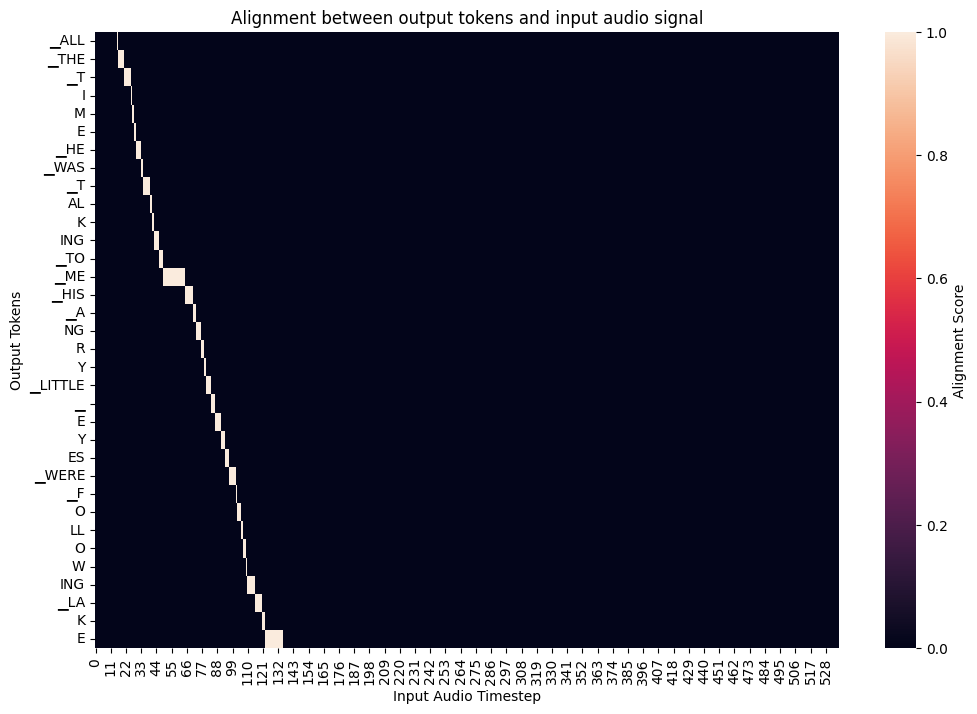

tensor([120,   7,  82,   4,   9,   1,  35,  47,  82,  57,  29,  26,  22,  90,
         62,  16, 110,  11,  12, 145,   2,   1,  12,  50, 127,  31,   8,  69,
          8,  24,  26, 112,  29,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0])
ALL THE TIME HE WAS TALKING TO ME HIS ANGRY LITTLE EYES WERE FOLLOWING LAKE ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  

In [33]:
all_tokens=array_of_all_tokens(tokenizer)
plotting(test_data,all_tokens)
print_gt(tokenizer,ground_truth_tokens)